<a href="https://colab.research.google.com/github/xiaoyingyang96/Molecular-Properties-Prediction-by-GNN/blob/main/SAGE_BBBP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO

In [ ]:

import torch
pytorch_version = "torch-" + torch.__version__ + ".html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/
pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/
pytorch_version
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/
ERROR: Could not find a version that satisfies the requirement torch-scatter (from versions: none)
ERROR: No matching distribution found for torch-scatter
Looking in links: https://pytorch-geometric.com/whl/
ERROR: Could not find a version that satisfies the requirement torch-cluster (from versions: none)
ERROR: No matching distribution found for torch-cluster
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.6 MB/s eta 0:00:00


In [ ]:
!pip install deepchem
import deepchem as dc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 13.0 MB/s eta 0:00:00


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [ ]:
import pandas as pd
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import rdmolops, Draw
import os

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# source of data: http://moleculenet.ai/datasets-1
smile_path = '/content/drive/MyDrive/GraphData/'
smile_name = 'BBBP.csv'

smile = pd.read_csv(os.path.join(smile_path, smile_name))
smile.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [ ]:

smile.shape

(2050, 4)

In [ ]:
print(smile['p_np'].value_counts())


p_np
1    1567
0     483
Name: count, dtype: int64


In [ ]:
#Setting weights for loss function
weight_for_one = sum(smile['p_np']== 0.0) / len(smile)
weight_for_zero = sum(smile['p_np'] == 1.0) / len(smile)
weights = torch.tensor([weight_for_zero, weight_for_one])

print('Weight for positive prediction: ', weight_for_one)
print('Weight for negative prediction: ', weight_for_zero)

Weight for positive prediction:  0.23560975609756096
Weight for negative prediction:  0.764390243902439


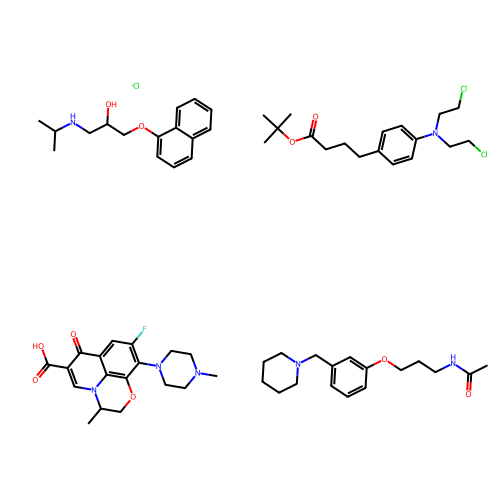

In [ ]:

first_ten = smile["smiles"][:4].values
first_ten = [Chem.MolFromSmiles(smiles) for smiles in first_ten]
grid = Draw.MolsToGridImage(first_ten, molsPerRow=2, subImgSize=(250,250))
grid

In [ ]:
from deepchem.feat.base_classes import MolecularFeaturizer


In [ ]:
class MoleculeDataset(Dataset):
  def __init__(self, root, transform=None, pre_transform=None):
    super(MoleculeDataset, self).__init__(root, transform, pre_transform)

  @property
  def raw_file_names(self):
    return 'BBBP_P.csv'

  @property
  def processed_file_names(self):
    return 'not_implemented.pt'

  def download(self):
    pass

  def process(self):
    self.data = pd.read_csv(self.raw_paths[0])
    #self.data.drop(labels=['num', 'name'], axis=1, inplace=True)
    #self.corrupted_molecules = 0
    self.count = 0
    featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
    for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
      try: #stan zero
        molecule = Chem.MolFromSmiles(mol["smiles"])
      except:
        #print(index)
        #self.corrupted_molecules += 1
        continue
      if molecule is not None:


        # node_features = self._get_node_features(molecule)
        # edge_features = self._get_edge_features(molecule)
        # edge_index = self._get_adjecency_info(molecule)

        out = featurizer.featurize(mol["smiles"])
        node_features = torch.tensor(out[0].node_features, dtype=torch.float)
        edge_features = torch.tensor(out[0].edge_features, dtype=torch.float)
        edge_index = torch.tensor(out[0].edge_index, dtype=torch.long)

        label = self._get_labels(mol['p_np'])

        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y=label, smiles=mol['smiles'])
        #torch.save(data, os.path.join(self.processed_dir, f'data_{index-self.corrupted_molecules}.pt'))
        torch.save(data, os.path.join(self.processed_dir, f'data_{index}.pt'))
      else:
        self.count += 1
      # except:
      #   print(index)
      #   self.corrupted_molecules += 1
      #   pass
    # print('Number of corrupted molecules: ', self.corrupted_molecules)
    print("End:", self.count)

  def _get_node_features(self, molecule):

    all_node_features = []

    for atom in molecule.GetAtoms():
      node_fts = []
      node_fts.append(atom.GetAtomicNum()) #atomic number
      node_fts.append(atom.GetFormalCharge()) #formal charge
      node_fts.append(atom.GetChiralTag()) #chiral tag
      node_fts.append(atom.GetIsAromatic()) #is aromatic
      all_node_features.append(node_fts)

    all_node_features = np.asarray(all_node_features)
    return torch.tensor(all_node_features, dtype=torch.float)


  def _get_edge_features(self, molecule):

    all_edge_features = []

    for bond in molecule.GetBonds():
      edge_fts = []
      edge_fts.append(bond.GetBondTypeAsDouble()) #bond type as double
      edge_fts.append(bond.GetStereo()) #bond stereo
      all_edge_features.append(edge_fts)

    all_edge_features = np.asarray(all_edge_features)
    return torch.tensor(all_edge_features, dtype=torch.float)

  def _get_adjecency_info(self, molecule):
    edge_indices = []
    for bond in molecule.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices += [[i, j], [j, i]]

    edge_indices = torch.tensor(edge_indices)
    edge_indices = edge_indices.t().to(torch.long).view(2, -1)
    return edge_indices

  def _get_labels(self, label):
    label = np.asarray([[label]])
    res = torch.tensor(label, dtype=torch.int64)
    return res

  def len(self):
    return self.data.shape[0]

  def get(self, idx):
    data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
    return data

In [ ]:
data_folder = '/content/drive/MyDrive/GraphData/'
data = MoleculeDataset(root=data_folder)

Processing...
  3%|▎         | 59/2039 [00:12<07:27,  4.43it/s][20:16:19] WARNING: not removing hydrogen atom without neighbors
[20:16:19] WARNING: not removing hydrogen atom without neighbors
  6%|▌         | 125/2039 [00:27<07:14,  4.40it/s][20:16:34] WARNING: not removing hydrogen atom without neighbors
[20:16:34] WARNING: not removing hydrogen atom without neighbors
 10%|▉         | 194/2039 [00:44<07:36,  4.04it/s][20:16:50] WARNING: not removing hydrogen atom without neighbors
[20:16:50] WARNING: not removing hydrogen atom without neighbors
 11%|█         | 221/2039 [00:51<06:46,  4.47it/s][20:16:57] WARNING: not removing hydrogen atom without neighbors
[20:16:57] WARNING: not removing hydrogen atom without neighbors
 15%|█▌        | 307/2039 [01:11<07:37,  3.79it/s][20:17:18] WARNING: not removing hydrogen atom without neighbors
[20:17:18] WARNING: not removing hydrogen atom without neighbors
[20:17:18] WARNING: not removing hydrogen atom without neighbors
[20:17:18] WARNING: no

End: 0



Done!


In [ ]:

print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

Dataset type:  <class '__main__.MoleculeDataset'>
Dataset features:  30
Dataset length:  <bound method MoleculeDataset.len of MoleculeDataset(2039)>
Dataset sample:  Data(x=[20, 30], edge_index=[2, 40], edge_attr=[40, 11], y=[1, 1], smiles='[Cl].CC(C)NCC(O)COc1cccc2ccccc12')
Sample  nodes:  20
Sample  edges:  40


In [ ]:
print('Edge indexes in coo format: ', data[0].edge_index.t()) #edge indexes in coo format
print('\n Node features: ', data[0].x) #node features matrix
print('\n Edge features: ', data[0].edge_attr) #edge features matrix
print('\n Label: ', data[0].y) # label

Edge indexes in coo format:  tensor([[ 1,  3],
        [ 3,  1],
        [ 3,  7],
        [ 7,  3],
        [ 3, 16],
        [16,  3],
        [16, 12],
        [12, 16],
        [12, 17],
        [17, 12],
        [17, 11],
        [11, 17],
        [17, 15],
        [15, 17],
        [15, 13],
        [13, 15],
        [13, 18],
        [18, 13],
        [18,  5],
        [ 5, 18],
        [ 5,  8],
        [ 8,  5],
        [ 8,  4],
        [ 4,  8],
        [ 4,  9],
        [ 9,  4],
        [ 9, 10],
        [10,  9],
        [10, 14],
        [14, 10],
        [14, 19],
        [19, 14],
        [19,  6],
        [ 6, 19],
        [ 6,  2],
        [ 2,  6],
        [ 2, 18],
        [18,  2],
        [ 2,  9],
        [ 9,  2]])

 Node features:  tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0.,

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 256

class SAGE(torch.nn.Module):
    def __init__(self):
        super(SAGE, self).__init__()
        torch.manual_seed(42)

        self.initial_conv = SAGEConv(data.num_features, embedding_size)
        self.conv1 = SAGEConv(embedding_size, embedding_size)
        self.conv2 = SAGEConv(embedding_size, embedding_size)

        self.linear1 = Linear(embedding_size*2, embedding_size)
        self.linear2 = Linear(embedding_size, 1)

    def forward(self, x, edge_index, batch_index):
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.relu(hidden)

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Output
        hidden = self.linear1(hidden).relu()
        hidden = F.dropout(hidden, p=0.2, training=self.training)
        hidden = self.linear2(hidden)
        out = torch.sigmoid(hidden)

        return out, hidden

In [ ]:
model = SAGE()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

SAGE(
  (initial_conv): SAGEConv(30, 256, aggr=mean)
  (conv1): SAGEConv(256, 256, aggr=mean)
  (conv2): SAGEConv(256, 256, aggr=mean)
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=1, bias=True)
)
Number of parameters:  409857


In [ ]:
from torch_geometric.data import DataLoader
# import warning
# warnings.filterwarnings("ignore")

In [ ]:
# Root mean squared error
loss_fn = torch.nn.BCELoss()

In [ ]:
# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# #Data split
train_percent = 0.8
validate_percent = 0.1
train_index = int(train_percent*len(data))
valid_index = int(validate_percent*len(data))

data = data.shuffle()
train_dataset = data[:train_index]
valid_dataset = data[train_index:(train_index+valid_index)]
test_dataset = data[(train_index+valid_index):]

print('Length of train dataset: ', len(train_dataset))
print('Length of validation dataset: ', len(valid_dataset))
print('Length of test dataset: ', len(test_dataset))

Length of train dataset:  1631
Length of validation dataset:  203
Length of test dataset:  205


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 128

train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(epoch):
    for batch in train_loader:
      # Use GPU
      batch.to(device)
      # Reset gradients
      optimizer.zero_grad()
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
      loss = torch.sqrt(loss_fn(pred, batch.y.float()))  # could get rid of sqrt
      loss.backward()
      # Update using the gradients
      optimizer.step()
    return loss, embedding

def valid(epoch):
  for batch in valid_loader:
    batch.to(device)
    optimizer.zero_grad()
    # Passing the node features and the connection info
    pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
    loss = torch.sqrt(loss_fn(pred, batch.y.float()))  # could get rid of sqrt
    loss.backward()
    # Update using the gradients
    optimizer.step()
  return loss, embedding

print("Starting training...")
losses = []
losses_valid = []
for epoch in range(1000):
    model.train()
    loss, h = train(epoch=epoch)
    loss = loss.detach().cpu().numpy()
    losses.append(loss)
    print(f"Epoch {epoch} | Train Loss {loss}")

    model.eval()
    if epoch % 5 == 0:
      loss, h = valid(epoch=epoch)
      loss = loss.detach().cpu().numpy()
      losses_valid.append(loss)
      print(f"Epoch {epoch} | Valid Loss {loss}")

print("Done")

Starting training...
Epoch 0 | Train Loss 0.7415096759796143
Epoch 0 | Valid Loss 0.6590654253959656
Epoch 1 | Train Loss 0.7095888257026672
Epoch 2 | Train Loss 0.7003487348556519
Epoch 3 | Train Loss 0.7012096643447876
Epoch 4 | Train Loss 0.6005417704582214
Epoch 5 | Train Loss 0.5730453133583069
Epoch 5 | Valid Loss 0.6007916927337646
Epoch 6 | Train Loss 0.6494944095611572
Epoch 7 | Train Loss 0.6022564768791199
Epoch 8 | Train Loss 0.7761576771736145
Epoch 9 | Train Loss 0.6031020879745483
Epoch 10 | Train Loss 0.4576988220214844
Epoch 10 | Valid Loss 0.6114642024040222
Epoch 11 | Train Loss 0.5427055358886719
Epoch 12 | Train Loss 0.5769757628440857
Epoch 13 | Train Loss 0.5258291363716125
Epoch 14 | Train Loss 0.479804128408432
Epoch 15 | Train Loss 0.5264453887939453
Epoch 15 | Valid Loss 0.4613569676876068
Epoch 16 | Train Loss 0.49704858660697937
Epoch 17 | Train Loss 0.4332144260406494
Epoch 18 | Train Loss 0.5075334310531616
Epoch 19 | Train Loss 0.5327569842338562
Epoch 2

KeyboardInterrupt: 

In [ ]:
!pip install torchviz
import torchviz
from torchviz import make_dot


  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

<ipython-input-28-399550ad5555>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


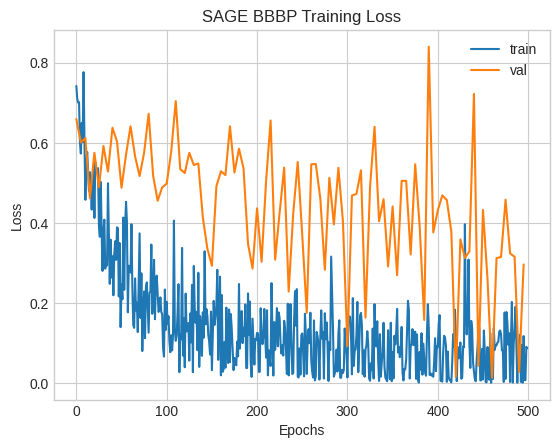

In [ ]:
import seaborn as sns
losses_float = [float(loss) for loss in losses]
loss_indices = [i for i,l in enumerate(losses)]

losses_valid_float = [float(loss) for loss in losses_valid]
loss_indices_valid = [i for i,l in enumerate(losses_valid)]

loss_indices_valid = [x * 5 for x in loss_indices_valid]

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

fig = plt.figure()
ax = plt.axes()

plt.plot(loss_indices[:500], losses_float[:500], label='train');
plt.plot(loss_indices_valid[:100], losses_valid_float[:100], label='val')
plt.title("SAGE BBBP Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
plt.show()

# print(type(losses_float))
# plt = sns.lineplot(list(range(200)), losses)
# plt

In [ ]:
import pandas as pd

# Assuming test_loader, model, and device are defined elsewhere and properly initialized

results = []  # List to hold batch results

for test_batch in test_loader:
    with torch.no_grad():
        test_batch.to(device)
        pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
        out = (pred > 0.5).float()

        # Accumulate results
        batch_results = [{"y_real": y.item(), "y_pred": yp.item()} for y, yp in zip(test_batch.y, out)]
        results.extend(batch_results)

# Convert the accumulated results into a DataFrame
df = pd.DataFrame(results, columns=["y_real", "y_pred"])

print(df)

     y_real  y_pred
0         1     1.0
1         1     1.0
2         1     1.0
3         1     1.0
4         1     1.0
..      ...     ...
200       1     1.0
201       1     1.0
202       1     1.0
203       1     1.0
204       0     1.0

[205 rows x 2 columns]


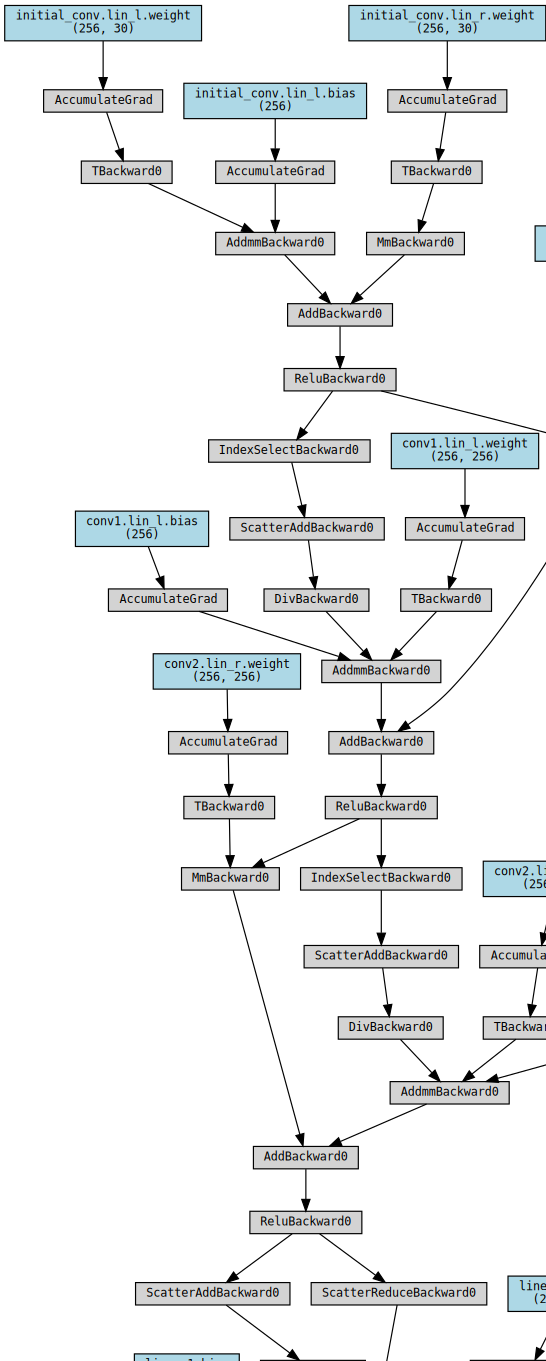

In [ ]:
#yhat = model(batch.x.float(), batch.edge_index, batch.batch)

test_batch = next(iter(train_loader))
# with torch.no_grad():
test_batch.to(device)
pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
make_dot(pred, params=dict(list(model.named_parameters())))

In [ ]:
print(df["y_real"].shape)

(205,)


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(df["y_real"], df["y_pred"])

0.8390243902439024

In [ ]:
from sklearn.metrics import f1_score
f1_score(df["y_real"], df["y_pred"])

0.8971962616822431

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df["y_real"], df["y_pred"])

0.7445161290322582

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

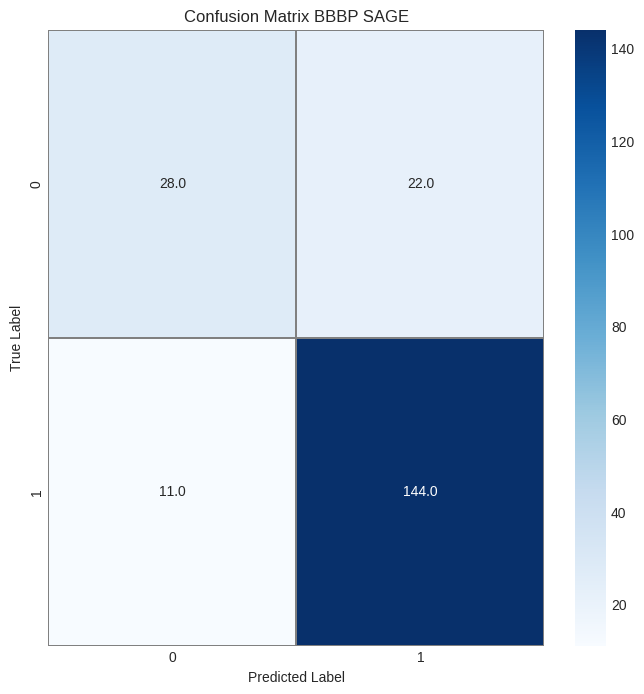

In [ ]:
cm = confusion_matrix(df["y_real"], df["y_pred"])

# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.title("Confusion Matrix BBBP SAGE")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
report = classification_report(y_true=df["y_real"], y_pred=df["y_pred"], target_names=["0", "1"])
print(report)

              precision    recall  f1-score   support

           0       0.72      0.56      0.63        50
           1       0.87      0.93      0.90       155

    accuracy                           0.84       205
   macro avg       0.79      0.74      0.76       205
weighted avg       0.83      0.84      0.83       205

